# Selección de clientes RandomSampling - Método _baseline_

En este notebook vamos a entrenar un modelo de ML utilizando el paradigma de Aprendizaje Federado [1] para los problemas de clasificación de dígitos manuscritos MNIST [2] y clasificación de imágenes a color CIFAR-10 [3]. Usaremos estos dos problemas de visión por computador para la implementación y análisis de rendimiento del método RandomSampling para la selección de clientes.

> [1] https://arxiv.org/abs/1602.05629
>
> [2] http://yann.lecun.com/exdb/mnist
>
> [3] https://www.cs.toronto.edu/~kriz/cifar.html

In [35]:
# install FLEXible framework if not installed
try:
    import flex
    print("FLEXible is installed.")
except:
    print("FLEXible is not installed.\nInstalling dependency flexible-fl...")
    !pip install flexible-fl

FLEXible is installed.


In [36]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(loss, accuracy, title="Learning Curves"):
    # Example data
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'g', label='Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)

    # Show the plots
    plt.tight_layout()
    plt.show()

In [37]:
import torch

# select device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cpu'

# Cargar datasets - MNIST, CIFAR-10

Cargaremos $2$ de los datasets que usaremos para entrenar el modelo de ML.

## MNIST
El primero será MNIST (Modified National Institute of Standards and Technology database), que consiste en imágenes de $28$ pixeles de ancho y alto en escala de grises de dígitos manuscritos del $0$ al $9$. Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{28\times 28}, x_i \in \{1, ..., 255\}$, donde $x_i$ es un pixel de la imagen $X$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ que representa el dígito al que corresponde la imagen. El conjunto de entrenamiento consta de $N=240,000$ imágenes.

El dataset descargado será el de _Extended MNIST_ [1], que comprende una versión extendida del concepto original de MNIST para proporcionar dígitos y letras manuscritas, una cantidad más grande de datos, diferentes formas de separar los datos (solo dígitos, letras, por clase, ...), etc. Nosotros solo utilizaremos los dígitos para entrenar el clásico MNIST, del cual su versión extendida consta de $N = 280,000$ imágenes de dígitos manuscritos.

Una característica importante de EMNIST es que cada imagen tendrá asociado un autor (i.e. la persona que ha escrito el dígito o letra), tal que un dígito es escrito por un solo autor pero un autor puede escribir muchos dígitos. Esto nos da la ventaja de poder distribuir los datos de forma No-IID tal que cada cliente tendrá los datos con autoría de un solo autor.

FLEX nos da utilidades para cargar EMNIST y federarlo automáticamente con la función `load`, donde además descargamos el dataset de test y solo usaremos el dataset de dígitos clásico de MNIST. Definimos también las transformaciones a realizar a los datos que son simplemente normalizar cada pixel a valores de $[0,1]$ (función `ToTensor()`) y normalizar los valores de cada pixel con una media y desviación estándar de $0.5$.

> [1] https://www.nist.gov/itl/products-and-services/emnist-dataset

In [38]:
from flex.datasets import load
from torchvision import transforms

flex_dataset_mnist, test_data = load("federated_emnist", return_test=True, split="digits")

# Assign test data to server_id
server_id = "server"
flex_dataset_mnist[server_id] = test_data

# apply transforms
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

[sultan]: md5 -q ./emnist-digits.mat;
DEBUG:sultan:md5 -q ./emnist-digits.mat;
[sultan]: Unable to run 'md5 -q ./emnist-digits.mat;'
CRITICAL:sultan:Unable to run 'md5 -q ./emnist-digits.mat;'
[sultan]: --{ TRACEBACK }----------------------------------------------------------------------------------------------------
CRITICAL:sultan:--{ TRACEBACK }----------------------------------------------------------------------------------------------------
[sultan]: | NoneType: None
CRITICAL:sultan:| NoneType: None
[sultan]: | 
CRITICAL:sultan:| 
[sultan]: -------------------------------------------------------------------------------------------------------------------
CRITICAL:sultan:-------------------------------------------------------------------------------------------------------------------
[sultan]: --{ STDERR }-------------------------------------------------------------------------------------------------------
CRITICAL:sultan:--{ STDERR }---------------------------------------------

## CIFAR-10

El segundo dataset es CIFAR-10 (_Canadian Institute for Advanced Research_)[1], el cual es otro de los datasets junto con MNIST, más utilizados en el campo del Deep Learning y Visión por Computador. CIFAR-10 consiste en una colección de imágenes de $32$ pixeles de altura y de ancho a color ($3$ canales RGB) representando $10$ objetos reales:
- Avión (airplane)
- Automóvil (automobile)
- Pájaro (bird)
- Gato (cat)
- Ciervo (deer)
- Perro (dog)
- Rana (frog)
- Caballo (horse)
- Barco (ship)
- Camión (truck)

Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{32\times 32 \times 3}, x_i \in \{1, ..., 255\}$, donde $x_i^c$ es un pixel de la imagen $X$ en el canal $c$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ tal que indexa la lista de clases $C=(c_0=\text{plane}, c_1=\text{automobile}, ..., c_9=\text{truck})$. El conjunto de entrenamiento consta de $N=50,000$ datos de entrada.

A diferencia de EMNIST, FLEX no carga por defecto CIFAR-10, por lo que deberemos de descargar y federar manualmente el dataset. Utilizaremos el dataset descargado desde `torchvision` de PyTorch y federamos utilizando una configuración por defecto de FLEX con un número de nodos o clientes de $K = 100$ clientes. Definimos también las transformaciones para escalar los valores a $[0,1]$ y normalizar con medias y desviaciones estándar específicas de CIFAR-10 [2].

> [1] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [2] https://github.com/kuangliu/pytorch-cifar/issues/19

In [39]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from flex.data import FedDataDistribution, FedDatasetConfig, Dataset

train_data = datasets.CIFAR10(
    root=".",
    train=True,
    download=True,
    transform=None,  # we apply them later in training process
)

test_data = datasets.CIFAR10(
    root=".",
    train=False,
    download=True,
    transform=None,  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = 100

# create Federated data distribution of CIFAR-10
flex_dataset_cifar = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data),
    config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_cifar[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalizar con las medias y desviaciones estándar específicas de CIFAR-10
])

Files already downloaded and verified
Files already downloaded and verified


# Modelos de aprendizaje

Definimos dos modelos de Machine Learning, uno para cada uno de los dos datasets que hemos definido anteriormente. Para ambos problemas, usaremos como función de pérdida o _criterion_ la función de entropía cruzada o _Cross Entropy Loss_ cuya definición [1] la define como (para una muestra $n$):

$$l_n = -w_{y_n} \cdot \log \frac{\exp (x_n, y_n)}{\sum_{c=0}^C \exp (x_n, c)} =-w_{y_n}\cdot \log (\text{Softmax} (x_n, y_n))$$

En ambos problemas utilizaremos Adam [2] como optimizador o algoritmo de aprendizaje. Utilizaremos los mismos parámetros que en [2] al haber hecho los experimentos sobre modelos similares y con los mismos datasets que estamos usando y que han demostrando buenos resultados: $\eta = 0.01$ y $\beta_1 = 0.9,\beta_2 = 0.999$. Estos parámetros están definidos por defecto en la librería de PyTorch [3].

> [1] https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
>
> [2] https://arxiv.org/abs/1412.6980
>
> [3] https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

---




## Perceptrón Multicapa (MNIST)

El primero, que lo usaremos para ajustar MNIST, será un Perceptrón Multicapa (MLP) de dos capas ocultas de $128$ parámetros la primera y $10$ la segunda (correspondiente al número de clases), y usando ReLU [1] como función de activación.

El modelo inicialmente lo tendrá el servidor y será copiado a cada uno de los clientes. En FLEX usamos el decorador `@init_model_server` para inicializar el modelo en el servidor, donde también podemos además de nuestra arquitectura del modelo, el optimizador y la función de pérdida a usar.

> [1] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [40]:
from typing import Tuple

import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """
    Multi-layer Perceptron classifier with two hidden layers.
    """
    def __init__(self, in_features: Tuple[int, int], hidden_features: int, num_classes: int = 10):
        super().__init__()

        width, height = in_features

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(width * height, hidden_features)
        self.fc2 = nn.Linear(hidden_features, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

## Red Neuronal Convolucional (CNN) - CIFAR-10

Para nuestro segundo problema, que consta de ajustar un modelo para clasificar CIFAR-10, utilizaremos un red neuronal convolucional o CNN. A diferencia de MNIST, CIFAR-10 tiene unos datos de entrada con una dimensionalidad más compleja, por lo que utilizar una CNN reduciría la cantidad de parámetros necesarios a entrenar.

Concretamente, la arquitectura de la red a implementar será la de una CNN estándar que comprende seis capas convolucionales (CONV) $3\times 3$:
- Pares de $32$, $64$ y $128$ canales consecutivos.
- Cada uno de ellos activados por ReLU y usando _Batch normalization_ (batchnorm).
- Y aplicando _Max Pooling_ $2\times 2$ cada dos capas convolucionales para reducir la dimensionalidad los mapas de activación.

Seguido de $3$ capas _Fully-Connected_ de $382$ y $192$ unidades activadas por ReLU para las capas ocultas y de $10$ unidades activada por Softmax para la capa de salida.

In [41]:
class CNN(nn.Module):
    """
    Convolucional Neural Net classifier for CIFAR-10 image recognition (32x32 images).
    """
    def __init__(self, in_channels: int = 3, num_classes: int = 10):
        super(CNN, self).__init__()

        # Conv layers
        self.bn1 = nn.BatchNorm2d(32)

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn3 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # FC layers
        self.flatten = nn.Flatten()

        hidden_dims = [382, 192]
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=hidden_dims[0])
        self.fc2 = nn.Linear(in_features=hidden_dims[0], out_features=hidden_dims[1])
        self.fc3 = nn.Linear(in_features=hidden_dims[1], out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn1(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.bn2(self.conv4(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv5(x)))
        x = F.relu(self.bn3(self.conv6(x)))
        x = self.pool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

## Configuración básica de escenario de FL

Configuraremos un escenario de aprendizaje federado centralizado (CFL) usando la librería FLEXible. FLEXible [1], o simplemente FLEX, es una librería de Python que proporciona un framework para la construcción de entornos de aprendizaje federado para fines de investigación y simulación. FLEX pretende dar flexibilidad en cuanto la gran variedad de escenarios y necesidades que se pueden llegar a plantear para experimentar en entornos federados.

Uno de nuestros objetivos es _integrar_ un método o técnica de selección de clientes en un escenario inicial de FL. La flexibilidad de FLEX nos permitirá conseguir este objetivo gracias a su flujo de mensajes entre entidades separadas por roles, y por la arquitectura modular de estas que nos permiten almacenar información de manera conveniente [1].

> [1] https://arxiv.org/abs/2404.06127
---

### Inicialización del modelo del servidor

El primer paso de nuestro bucle de entrenamiento en aprendizaje federado es inicializar el modelo FLEX del servidor (que posteriormente se distribuirá a los clientes).

Con FLEX podemos hacer uso del decorador `init_server_model` para facilitarnos esta tarea. Esta función entonces debe de instanciar y devolver un modelo de FLEX en donde además definimos el modelo de aprendizaje $^1$, la función de pérdida, el optimizador y cualquier otra información que se usará en las demás fases de la ronda de entrenamiento.

Definimos dos funciones que realizan esta tarea, dos para cada una de nuestras arquitecturas, el Perceptrón Multicapa y la Red Neuronal Convolucional. Como habíamos especificado en el planteamiento del problema de ML a resolver, utilizaremos el optimizador SGD-Adam con sus parámetros por defecto, y la Cross-Entropy como función de pérdida.

> $^1$ No se debe confundir el modelo de tipo `FlexModel` con un modelo de ML. El primero implementa el bloque fundamental que define una entidad en el escenario de FL (donde almacenamos información, sus datos locales, su modelo de aprendizaje, ...). El segundo es un modelo aprendizaje como lo puede ser un módulo de PyTorch o Tensorflow que realiza el aprendizaje automático y la predicción sobre los datos. Se dejará claro la diferencia entre los dos tipos de modelos.


In [42]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel

mnist_in_features = (28, 28)
mnist_hidden_features = 128

@init_server_model
def build_server_model_mlp():
    server_flex_model = FlexModel()

    server_flex_model["model"] = MLP(mnist_in_features, mnist_hidden_features)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

cifar_in_channels = 3
cifar_num_classes = 10

@init_server_model
def build_server_model_cnn():
    server_flex_model = FlexModel()

    server_flex_model["model"] = CNN(cifar_in_channels, cifar_num_classes)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

---
### Distribuir modelo del servidor

El siguiente paso a realizar en un flujo de entrenamiento de aprendizaje federado es la distribución del modelo del servidor a los cientes. Con FLEX, podemos utilizar el decorador `@deploy_server_model` para distribuir el modelo del servidor a los clientes, definiendo una función que devuelva el modelo a almacenar en cada cliente.

En este caso, realizamos una copia profunda del modelo del servidor que será asignado a cada cliente.


In [43]:
from flex.pool import deploy_server_model
import copy


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    return copy.deepcopy(server_flex_model)

### Actualización del modelo del lado del cliente

Definimos la función encargada de realizar el entrenamiento del modelo sobre los datos locales del cliente. A esta función, es conveniente pasarle como parámetros los hiperparámetros de entrenamiento de un modelo de ML convencional como el número de épocas $E$ y el tamaño de _batch_ $B$

In [44]:
from flex.data import Dataset
from torch.utils.data import DataLoader


def train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse kwargs
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20

    # get client data as a torchvision object
    train_dataset = client_data.to_torchvision_dataset(transform=mnist_transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    # get model
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]

    # train model
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()


### Obtener los parámetros de los clientes

Ahora implementamos la función que hace que el servidor (con rol de agregador) recupere los nuevos parámetros actualizados de los clientes. Con el decorador `@collect_clients_weights` recuperamos los pesos de PyTorch de cada cliente seleccionado para esa ronda. En el caso de PyTorch, el modelo devuelve los pesos en forma de un diccionario con `state_dict` para el que cada nombre representa una capa de la red y sus parámetros, lo que hacemos será devolver una lista con los valores de ese diccionario correspondientes a los pesos de la red entera.

In [45]:
from flex.pool import collect_clients_weights


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    return [weight_dict[name] for name in weight_dict]

### Agregación de los parámetros

El servidor/agregador agrega entonces estos nuevos parámetros para conseguir el nuevo modelo global. Utilizamos el decorador `@aggregate_weights` para poder agregar los pesos que hemos recuperado de los clientes en la fase anterior computando la media de los pesos de manera uniforme, conocido como agregador FedAvg [1], donde realizamos la media por columnas para cada capa de pesos.

> [1] https://arxiv.org/abs/1602.05629

In [46]:
from flex.pool import aggregate_weights
import tensorly as tl

tl.set_backend("pytorch")


@aggregate_weights
def aggregate_with_fedavg(list_of_weights: list):
    agg_weights = []
    for layer_index in range(len(list_of_weights[0])):
        weights_per_layer = [weights[layer_index] for weights in list_of_weights]
        weights_per_layer = tl.stack(weights_per_layer)
        agg_layer = tl.mean(weights_per_layer, axis=0)
        agg_weights.append(agg_layer)
    return agg_weights

Finalmente, agregamos los pesos al modelo de nuestro servidor/agregador. Sencillamente, para cada capa de nuestro modelo, realizamo una copia del nuevo que hemos agregado en la fase anterior.

In [47]:
from flex.pool import set_aggregated_weights


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)

### Evaluación del modelo global

Podemos evaluar el modelo del servidor sobre el dataset de test que hemos definido anteriormente que residía en el mismo servidor. Para ello, definimos una función `evaluate_global_model` que obtenga las predicciones del modelo con el dataset de test y devuelva las metricas resultantes, que en este caso son simplemente la pérdida y la _accuracy_.

In [48]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform=mnist_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc

### Training loop

A continuación se muestra el bucle de entrenamiento aplicando todas las fases que hemos implementado anteriormente. En esta versión básica se implementa una selección aleatoria (RandomSampling), similar a la propuesta en [1] donde se selecciona de manera aleatoria y uniforme $M$ clientes para la ronda actual. Este proceso se repite de forma iterativa un número determinado de rondas.

In [49]:
def train_n_rounds(pool: FlexPool, n_rounds: int, clients_per_round=20):
    """
    Función de entrenamiento con aprendizaje federado para un número de rondas y un número de clientes seleccionados determinado.
    """
    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")
        selected_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")
        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # Each selected client trains her model
        selected_clients.map(train)
        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)
        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies


Running round: 1 of 20
Selected clients for this round: 20
Server: Test acc: 0.6878, test loss: 1.5820

Running round: 2 of 20
Selected clients for this round: 20
Server: Test acc: 0.7716, test loss: 0.9257

Running round: 3 of 20
Selected clients for this round: 20
Server: Test acc: 0.8355, test loss: 0.6421

Running round: 4 of 20
Selected clients for this round: 20
Server: Test acc: 0.8404, test loss: 0.5408

Running round: 5 of 20
Selected clients for this round: 20
Server: Test acc: 0.8463, test loss: 0.4857

Running round: 6 of 20
Selected clients for this round: 20
Server: Test acc: 0.8588, test loss: 0.4470

Running round: 7 of 20
Selected clients for this round: 20
Server: Test acc: 0.8690, test loss: 0.4148

Running round: 8 of 20
Selected clients for this round: 20
Server: Test acc: 0.8745, test loss: 0.3971

Running round: 9 of 20
Selected clients for this round: 20
Server: Test acc: 0.8804, test loss: 0.3810

Running round: 10 of 20
Selected clients for this round: 20
Ser

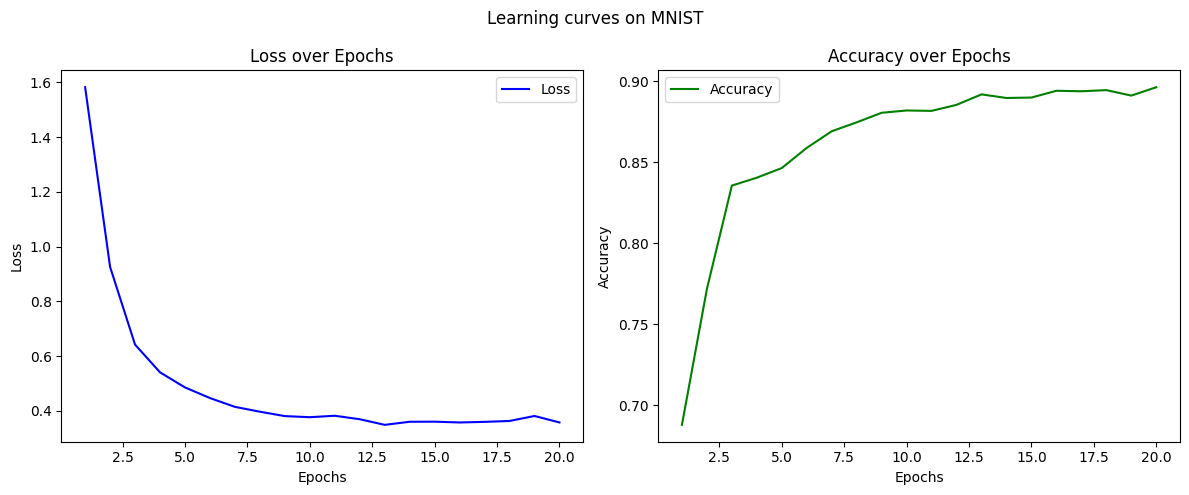

In [50]:
pool_mnist = FlexPool.client_server_pool(flex_dataset_mnist, init_func=build_server_model_mlp)
pool_cifar = FlexPool.client_server_pool(flex_dataset_mnist, init_func=build_server_model_mlp)

losses, accuracies = train_n_rounds(pool_mnist, n_rounds=20, clients_per_round=20)
plot_loss_accuracy(losses, accuracies, title="Learning curves on MNIST")


Running round: 1 of 20
Selected clients for this round: 20
Server: Test acc: 0.6711, test loss: 1.5613

Running round: 2 of 20
Selected clients for this round: 20
Server: Test acc: 0.8033, test loss: 0.8720

Running round: 3 of 20
Selected clients for this round: 20
Server: Test acc: 0.8313, test loss: 0.6241

Running round: 4 of 20
Selected clients for this round: 20
Server: Test acc: 0.8420, test loss: 0.5252

Running round: 5 of 20
Selected clients for this round: 20
Server: Test acc: 0.8573, test loss: 0.4599

Running round: 6 of 20
Selected clients for this round: 20
Server: Test acc: 0.8651, test loss: 0.4299

Running round: 7 of 20
Selected clients for this round: 20
Server: Test acc: 0.8681, test loss: 0.4174

Running round: 8 of 20
Selected clients for this round: 20
Server: Test acc: 0.8786, test loss: 0.3848

Running round: 9 of 20
Selected clients for this round: 20
Server: Test acc: 0.8836, test loss: 0.3676

Running round: 10 of 20
Selected clients for this round: 20
Ser

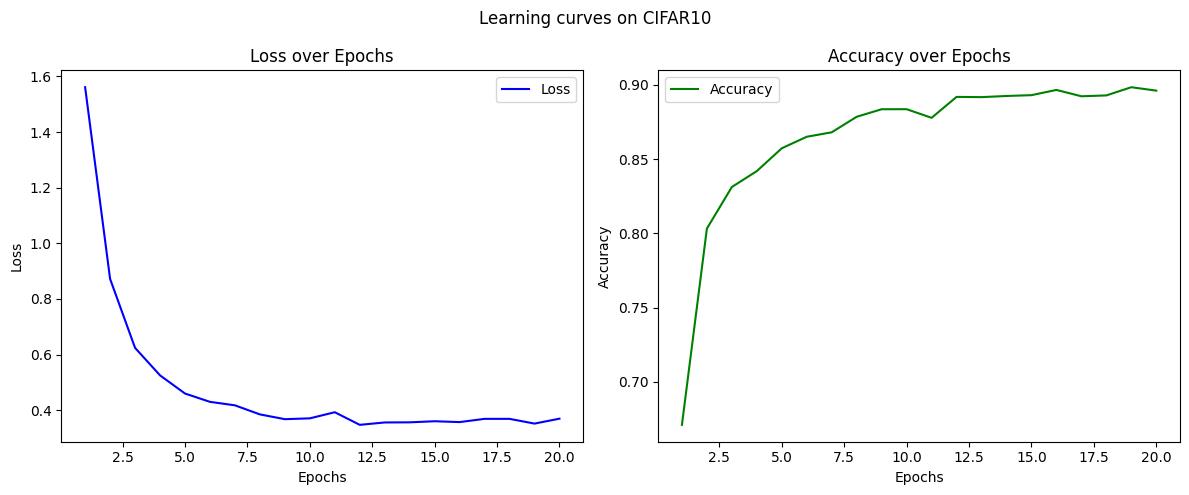

In [51]:
losses, accuracies = train_n_rounds(pool_cifar, n_rounds=20, clients_per_round=20)
plot_loss_accuracy(losses, accuracies, title="Learning curves on CIFAR10")